In [2]:
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
from utils import pareto_compare_plots, pareto_multicompare_plots, method_nice, reverse_metrics
from glob import glob
import pdb
import json
from tqdm import tqdm 
from collections import namedtuple
import numpy as np 


perf = namedtuple('perf',['method','dataset','seed'])
# rdir = 'results_r7'
rdirs = [
     '../results/Run_15/synthetic1/', 
    '../results/Run_15/synthetic1W/', 
#     '../fair_gp/analysis/results/'
]
performances = {} 
methods = set()
datasets = set()
seeds = set()
seedcount = {}
from pathlib import Path
# for f in tqdm(glob(rdir+'/*.json')):
frames = []
for rdir in rdirs:
    for f in Path(rdir).glob('*.json'):

        with open(f) as fh:
            perf = json.load(fh)
            
        for p in perf:
            for fold in ['train','test']:
                frame = {k:v for k,v in p.items() if k not in ['train','test']}
                frame['fold'] = fold
                method = frame['method']
                fairness = 'FPR' if 'fpr' in method else 'FNR'
                frame['fairness'] = fairness 
                frame['ML'] = 'Linear' if 'lr' in method else 'rf'
                frame['base_method'] = method.split('_')[0]
                if 'synthetic1W' in str(f):
                    frame['dataset'] = 'Synthetic1W'
                # if 'adultW' in str(f):
                #     frame['dataset'] = 'adultW'
                for metric,value in p[fold].items():
                    if metric.startswith('subgroup') or metric.startswith('auditor'):
                        if fairness.lower() not in metric:
                            continue
                        metric = metric.replace(fairness.lower(),'fairness')
                    frame[metric] = value
                frames.append(frame)
df_results = pd.DataFrame(frames)

In [3]:
df_results

,dataset,method,model,seed,fold,fairness,ML,base_method,accuracy,auc_prc,auc_roc,ave_precision_score,fpr,logloss,mae,precision,recall,subgroup_fairness
0,synthetic1,fomo_flex_lr_fnr,fomo_flex_lr_fnr:archive(0),27690,train,FNR,Linear,fomo,0.787742,0.925587,0.891084,0.925629,0.123226,0.401113,0.262679,0.800000,0.847007,0.012210
1,synthetic1,fomo_flex_lr_fnr,fomo_flex_lr_fnr:archive(0),27690,test,FNR,Linear,fomo,0.771613,0.917746,0.877124,0.917792,0.136129,0.423063,0.273854,0.782698,0.841639,0.012627
2,synthetic1,fomo_flex_lr_fnr,fomo_flex_lr_fnr:archive(1),27690,train,FNR,Linear,fomo,0.783226,0.924146,0.890788,0.924189,0.127742,0.409006,0.287151,0.794179,0.847007,0.012692
3,synthetic1,fomo_flex_lr_fnr,fomo_flex_lr_fnr:archive(1),27690,test,FNR,Linear,fomo,0.772258,0.916905,0.877592,0.916952,0.138065,0.425822,0.296036,0.781186,0.846069,0.012655
4,synthetic1,fomo_flex_lr_fnr,fomo_flex_lr_fnr:archive(2),27690,train,FNR,Linear,fomo,0.789677,0.918757,0.888713,0.918807,0.126452,0.495911,0.375123,0.797521,0.855876,0.009953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41555,Synthetic1W,fomo_nsga2_lr_fnr_mlp,fomo_nsga2_lr_fnr_mlp:archive(23),15860,test,FNR,Linear,fomo,0.795484,0.896564,0.871251,0.896637,0.120645,0.665620,0.485779,0.805005,0.855876,0.001337
41556,Synthetic1W,fomo_nsga2_lr_fnr_mlp,fomo_nsga2_lr_fnr_mlp:archive(24),15860,train,FNR,Linear,fomo,0.804516,0.909243,0.881378,0.909304,0.121290,0.642233,0.472972,0.807377,0.872647,0.001939
41557,Synthetic1W,fomo_nsga2_lr_fnr_mlp,fomo_nsga2_lr_fnr_mlp:archive(24),15860,test,FNR,Linear,fomo,0.800645,0.901203,0.872430,0.901270,0.133548,0.642372,0.472987,0.794439,0.886918,0.002063
41558,Synthetic1W,fomo_lex_lr_fnr_mlp,fomo_lex_lr_fnr_mlp:archive(0),29756,train,FNR,Linear,fomo,0.802581,0.894501,0.866942,0.894577,0.107097,0.603642,0.221478,0.821313,0.844961,0.012413


In [4]:
# filtered_df = df_results[(df_results['1 - AUROC'] > 1) | (df_results['1 - AUROC'] < 0)]
# filtered_df
df_results.columns
df_results = df_results[df_results['dataset'] != 'mimic4']

# data cleanup

In [4]:
from utils import method_nice, fair_metrics, loss_metrics, reverse_metrics
df_results['method'] = df_results['method'].apply(lambda x: method_nice[x])
df_results = df_results.rename(columns={'subgroup_fairness':'Subgroup Fairness'})
for c in df_results.columns:
    if c in reverse_metrics and c in loss_metrics:
        df_results[loss_metrics[c]] = 1-df_results[c]
df_results

,dataset,method,model,seed,fold,fairness,ML,base_method,accuracy,auc_prc,...,fpr,logloss,mae,precision,recall,Subgroup Fairness,1-Accuracy,1 - Area Under Precision-Recall Curve,1 - AUROC,1-Average Precision Score
0,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(0),27690,train,FNR,Linear,fomo,0.787742,0.925587,...,0.123226,0.401113,0.262679,0.800000,0.847007,0.012210,0.212258,0.074413,0.108916,0.074371
1,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(0),27690,test,FNR,Linear,fomo,0.771613,0.917746,...,0.136129,0.423063,0.273854,0.782698,0.841639,0.012627,0.228387,0.082254,0.122876,0.082208
2,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(1),27690,train,FNR,Linear,fomo,0.783226,0.924146,...,0.127742,0.409006,0.287151,0.794179,0.847007,0.012692,0.216774,0.075854,0.109212,0.075811
3,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(1),27690,test,FNR,Linear,fomo,0.772258,0.916905,...,0.138065,0.425822,0.296036,0.781186,0.846069,0.012655,0.227742,0.083095,0.122408,0.083048
4,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(2),27690,train,FNR,Linear,fomo,0.789677,0.918757,...,0.126452,0.495911,0.375123,0.797521,0.855876,0.009953,0.210323,0.081243,0.111287,0.081193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41555,Synthetic1W,NSGA2-LR-NN,fomo_nsga2_lr_fnr_mlp:archive(23),15860,test,FNR,Linear,fomo,0.795484,0.896564,...,0.120645,0.665620,0.485779,0.805005,0.855876,0.001337,0.204516,0.103436,0.128749,0.103363
41556,Synthetic1W,NSGA2-LR-NN,fomo_nsga2_lr_fnr_mlp:archive(24),15860,train,FNR,Linear,fomo,0.804516,0.909243,...,0.121290,0.642233,0.472972,0.807377,0.872647,0.001939,0.195484,0.090757,0.118622,0.090696
41557,Synthetic1W,NSGA2-LR-NN,fomo_nsga2_lr_fnr_mlp:archive(24),15860,test,FNR,Linear,fomo,0.800645,0.901203,...,0.133548,0.642372,0.472987,0.794439,0.886918,0.002063,0.199355,0.098797,0.127570,0.098730
41558,Synthetic1W,FLEX-LR-NN,fomo_lex_lr_fnr_mlp:archive(0),29756,train,FNR,Linear,fomo,0.802581,0.894501,...,0.107097,0.603642,0.221478,0.821313,0.844961,0.012413,0.197419,0.105499,0.133058,0.105423


# Pareto Front: combined histogram/scatter with density contours

In [5]:
df_plt = df_results
df_plt['dataset'].unique()

array(['synthetic1', 'Synthetic1W'], dtype=object)

In [104]:
# palette= sns.color_palette("Spectral",8)
# del palette[8] 
# del palette[7] 
# del palette[6] 
# del palette[5] 
# del palette[4] 
# del palette[3] 
# del palette[2] 
# palette

NameError: name 'plt' is not defined

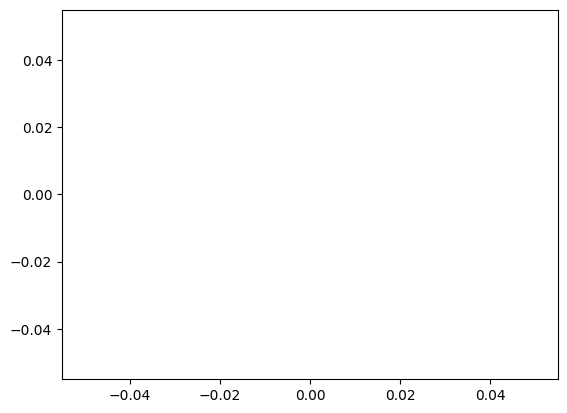

In [11]:
df_plt2 = df_results.copy()
df_plt2 = df_plt2.loc[
#     (df_plt.method.str.contains('fnr'))
#     & 
    (df_plt2.fold == 'test')
    &
    (df_plt2.dataset.isin(['ACSIncomeRA']))
#     &
#     df_plt.method.str.contains('FLEX-', case=False)
    &
    (df_plt2.method.isin(['NSGA2-LR-LIN']))
]

sns.kdeplot(df_plt2['Subgroup Fairness'], fill=False)
sns.histplot(df_plt2['Subgroup Fairness'], edgecolor='black', kde=False)
plt.title('Distribution of Values in "column_name"')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

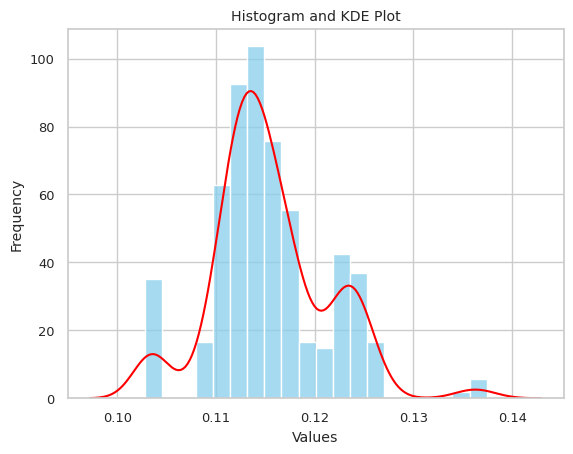

In [32]:
def plot_histogram_and_kde(data, xlabel='Values', title='Histogram and KDE Plot'):
    """
    Plot both a histogram and a KDE plot for a given column of data.

    Parameters:
    - data: Pandas Series or NumPy array, the column of data to be plotted.
    - xlabel: str, the label for the x-axis (default: 'Values').
    - title: str, the title of the plot (default: 'Histogram and KDE Plot').

    Returns:
    - None (displays the plot).
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the histogram
    sns.histplot(data, bins=20, kde=False, color='skyblue', ax=ax, stat="density")

    # Plot the KDE plot
    sns.kdeplot(data, color='red', ax=ax, common_norm=True, levels=2)

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title)

    # Show the plot
    plt.show()
    
df_plt2 = df_results.copy()
df_plt2 = df_plt2.loc[
#     (df_plt.method.str.contains('fnr'))
#     & 
    (df_plt2.fold == 'test')
    &
    (df_plt2.dataset.isin(['synthetic1']))
#     &
#     df_plt.method.str.contains('FLEX-', case=False)
    &
    
    (df_plt2.method.isin(['FLEX-LR-LIN']))
]    

plot_histogram_and_kde(df_plt2['1 - AUROC'])

In [8]:
df_results

,dataset,method,model,seed,fold,fairness,ML,base_method,accuracy,auc_prc,...,fpr,logloss,mae,precision,recall,Subgroup Fairness,1-Accuracy,1 - Area Under Precision-Recall Curve,1 - AUROC,1-Average Precision Score
0,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(0),27690,train,FNR,Linear,fomo,0.787742,0.925587,...,0.123226,0.401113,0.262679,0.800000,0.847007,0.012210,0.212258,0.074413,0.108916,0.074371
1,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(0),27690,test,FNR,Linear,fomo,0.771613,0.917746,...,0.136129,0.423063,0.273854,0.782698,0.841639,0.012627,0.228387,0.082254,0.122876,0.082208
2,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(1),27690,train,FNR,Linear,fomo,0.783226,0.924146,...,0.127742,0.409006,0.287151,0.794179,0.847007,0.012692,0.216774,0.075854,0.109212,0.075811
3,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(1),27690,test,FNR,Linear,fomo,0.772258,0.916905,...,0.138065,0.425822,0.296036,0.781186,0.846069,0.012655,0.227742,0.083095,0.122408,0.083048
4,synthetic1,FLEX+NSGA2-LR,fomo_flex_lr_fnr:archive(2),27690,train,FNR,Linear,fomo,0.789677,0.918757,...,0.126452,0.495911,0.375123,0.797521,0.855876,0.009953,0.210323,0.081243,0.111287,0.081193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41555,Synthetic1W,NSGA2-LR-NN,fomo_nsga2_lr_fnr_mlp:archive(23),15860,test,FNR,Linear,fomo,0.795484,0.896564,...,0.120645,0.665620,0.485779,0.805005,0.855876,0.001337,0.204516,0.103436,0.128749,0.103363
41556,Synthetic1W,NSGA2-LR-NN,fomo_nsga2_lr_fnr_mlp:archive(24),15860,train,FNR,Linear,fomo,0.804516,0.909243,...,0.121290,0.642233,0.472972,0.807377,0.872647,0.001939,0.195484,0.090757,0.118622,0.090696
41557,Synthetic1W,NSGA2-LR-NN,fomo_nsga2_lr_fnr_mlp:archive(24),15860,test,FNR,Linear,fomo,0.800645,0.901203,...,0.133548,0.642372,0.472987,0.794439,0.886918,0.002063,0.199355,0.098797,0.127570,0.098730
41558,Synthetic1W,FLEX-LR-NN,fomo_lex_lr_fnr_mlp:archive(0),29756,train,FNR,Linear,fomo,0.802581,0.894501,...,0.107097,0.603642,0.221478,0.821313,0.844961,0.012413,0.197419,0.105499,0.133058,0.105423


/home/shakiba/flex/flex/lib/python3.10/site-packages/seaborn/distributions.py:1210: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/shakiba/flex/flex/lib/python3.10/site-packages/seaborn/distributions.py:1210: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


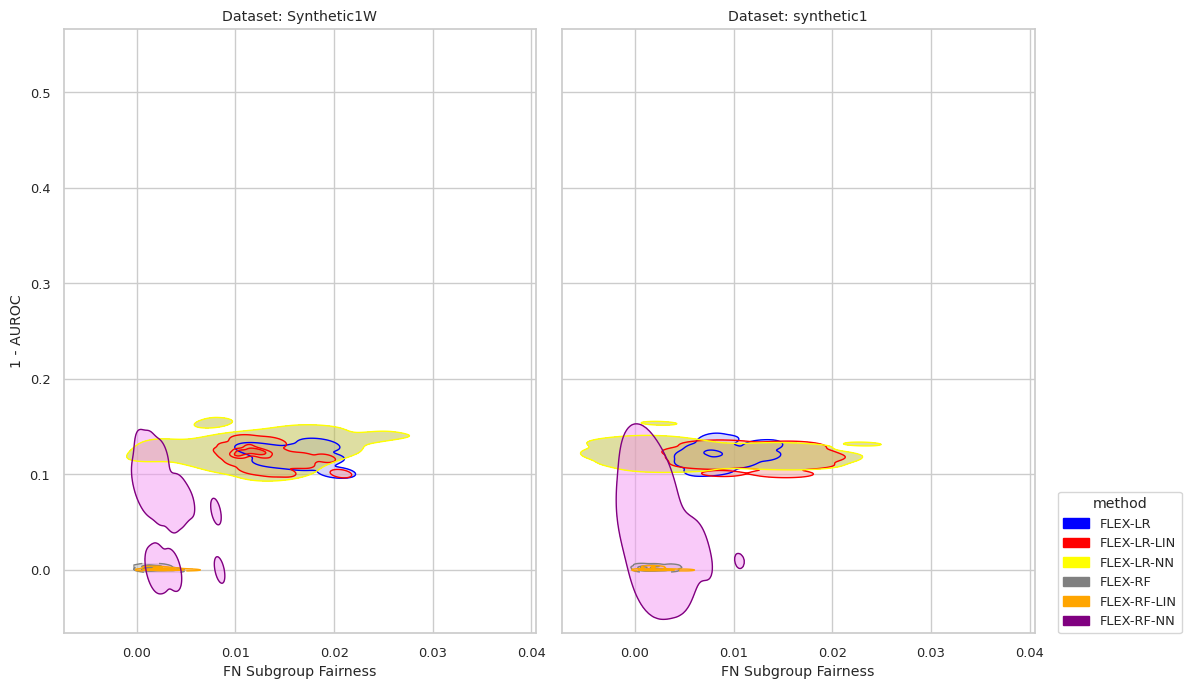

In [33]:
import matplotlib.pyplot as plt
sns.set(style='whitegrid',font_scale=0.85)
# size = 10

plot_dict = {
#'LR' : ['FLEX+NSGA2-LR', 'FLEX-LR', 'NSGA2-LR'],
#'LRLIN' : ['FLEX+NSGA2-LR-LIN', 'FLEX-LR-LIN', 'NSGA2-LR-LIN'],
#'LRNN' : ['FLEX+NSGA2-LR-NN', 'FLEX-LR-NN', 'NSGA2-LR-NN'],
#'RF' : ['FLEX+NSGA2-RF', 'FLEX-RF', 'NSGA2-RF'],
#'RFLIN': ['FLEX+NSGA2-RF-LIN', 'FLEX-RF-LIN', 'NSGA2-RF-LIN'],
#'RFNN' : ['FLEX+NSGA2-RF-NN', 'FLEX-RF-NN', 'NSGA2-RF-NN'],
#'FLEXNSGA2' : ['FLEX+NSGA2-LR', 'FLEX+NSGA2-LR-LIN', 'FLEX+NSGA2-LR-NN','FLEX+NSGA2-RF', 'FLEX+NSGA2-RF-LIN', 'FLEX+NSGA2-RF-NN'],
#'NSGA2' : ['NSGA2-LR', 'NSGA2-LR-LIN', 'NSGA2-LR-NN','NSGA2-RF', 'NSGA2-RF-LIN', 'NSGA2-RF-NN' ],
'FLEX' : ['FLEX-LR', 'FLEX-LR-LIN', 'FLEX-LR-NN','FLEX-RF', 'FLEX-RF-LIN', 'FLEX-RF-NN' ]
}

for p, values in plot_dict.items():

    df_plt = df_results.copy()
    df_plt = df_plt.loc[
    #     (df_plt.method.str.contains('fnr'))
    #     & 
        (df_plt.fold == 'train')
        &
        (df_plt.dataset.isin(['synthetic1', 'Synthetic1W']))
    #     &
    #     df_plt.method.str.contains('FLEX-', case=False)
        &
        (df_plt.method.isin(values))
    ]
    hue_order = values
    custom_palette = sns.color_palette(['blue', 'red', 'yellow', 'gray', 'orange', 'purple'])[:len(hue_order)]

    # s = np.argsort([method_nice[m] for m in models])
    # hue_order = models #[models[i] for i i,', 'red', 'yellow', 'purple', 'gray', 'orange'])

    x = 'Subgroup Fairness'
    y = '1 - AUROC'
    # hue = 'base_method'
    hue = 'method'
    style='ML'
    col='dataset'
    row='fairness'
    palette=custom_palette

    f, axs = plt.subplots(
        nrows = 1, 
        ncols=df_plt[col].nunique(), 
        figsize=(12, 7),
        sharey = 'all',
        sharex = 'all'

    )
    axs = axs.reshape(1, df_plt[col].nunique())

    i = 0
    for r, dfr in df_plt.groupby(row):
        j = 0
        for c, dfrc in dfr.groupby(col):
            ax = axs[i,j]
            shared_args = dict(
                ax=ax, 
                data=dfrc,  
                x=x, 
                y=y,
                hue=hue,
                hue_order=hue_order,
                palette=palette
            )

            # Draw a combo histogram and scatterplot with density contours
    #         xlim = ax.get_xlim()
    #         ylim = ax.get_ylim()
            legend = i==0 and j+1 == df_plt[col].nunique()
            try:
                g = sns.kdeplot(**shared_args,
                            levels=3,
    #                         color="w",
                            fill=True,
                            linewidths=1,
                            legend=legend,
                            alpha=0.5,
                            thresh=0.001
                           )
                sns.kdeplot(**shared_args,
                            levels=5,
                            fill=False,
                            linewidths=1,
                            legend=False,
                            thresh=0.001
                           )
    #             print()
            except:
                print('kde failed for',r,c)
    #             sns.scatterplot(
    #                 **shared_args, 
    #                 s=5,
    #                 legend = False,
    #             )
                sns.histplot(**shared_args,
                             bins=20,
        #                      pthresh=.01,
                             thresh=1,
                             legend=False
                            )

    #         ax.set_xlim(xlim)
    #         ax.set_ylim(ylim)

            if i == 0: 
                ax.set_title(f'Dataset: {c}')

            ax.set_xlabel(f'{r[:2]} Subgroup Fairness')
    #         if i+1 == df_plt[row].nunique():
    #         else:
    #             ax.set_xlabel('')

            if j == 0:
                ax.set_ylabel(f'{y.upper()}')
            else:
                ax.set_ylabel('')

            if legend:
                sns.move_legend(g, loc=[1.05,0])

            j += 1
        i += 1

    # plt.tight_layout()

    f.tight_layout(h_pad=2)
    f.savefig(f'figs15/pareto_dist/pareto_dist_train_{p}.png', bbox_inches='tight')

/tmp/ipykernel_4058/2167710311.py:53: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.kdeplot(**shared_args,
/home/shakiba/.local/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/tmp/ipykernel_4058/2167710311.py:62: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.kdeplot(**shared_args,
/tmp/ipykernel_4058/2167710311.py:53: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.kdeplot(**shared_args,
/home/shakiba/.local/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/tmp/ipykernel_4058/2167710311.py:62: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.kdeplot(**shared_args,
/tmp/ipykernel_4058/2167710311.py:53: UserWarn

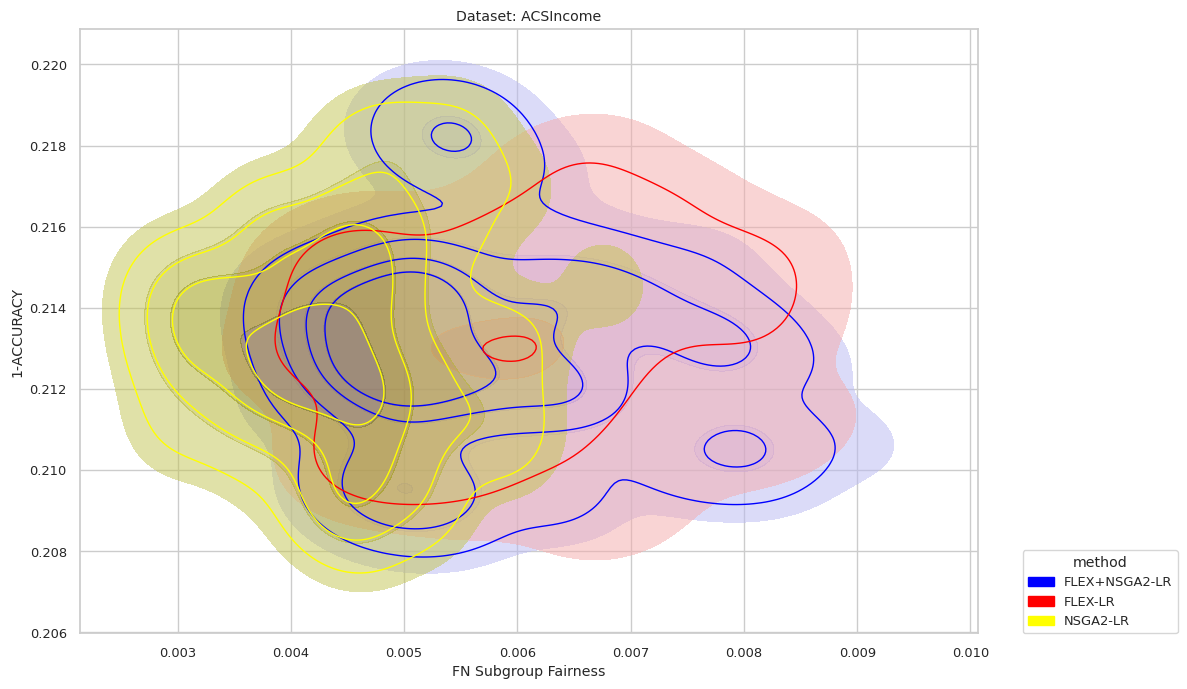

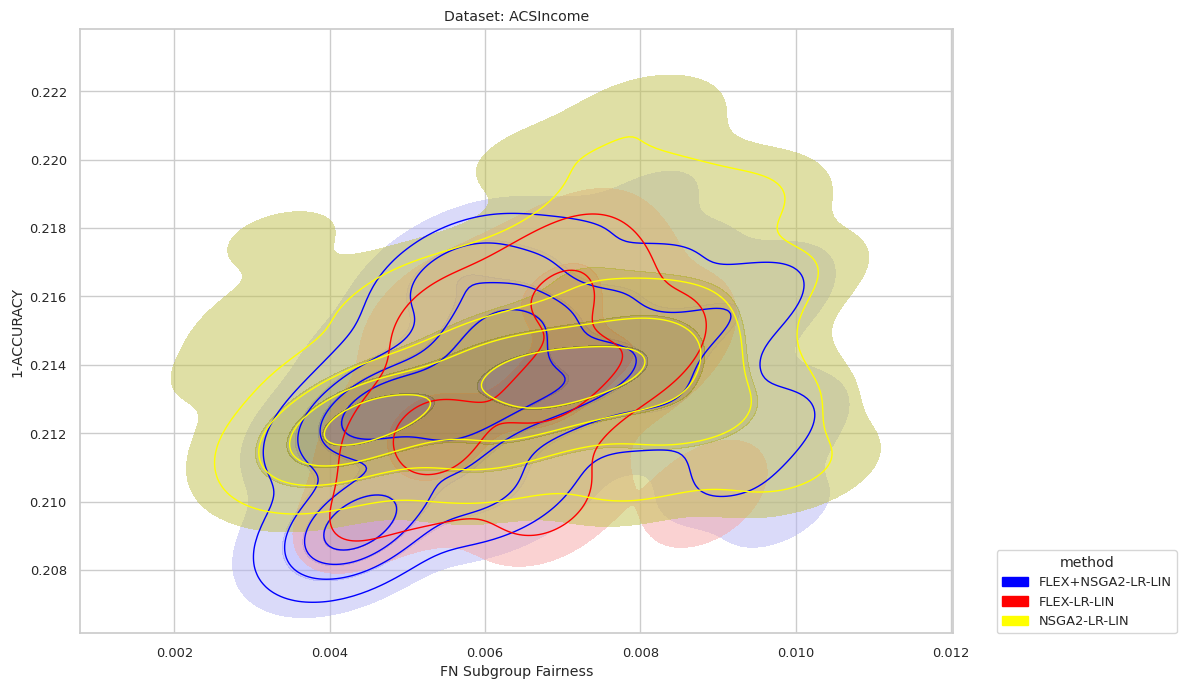

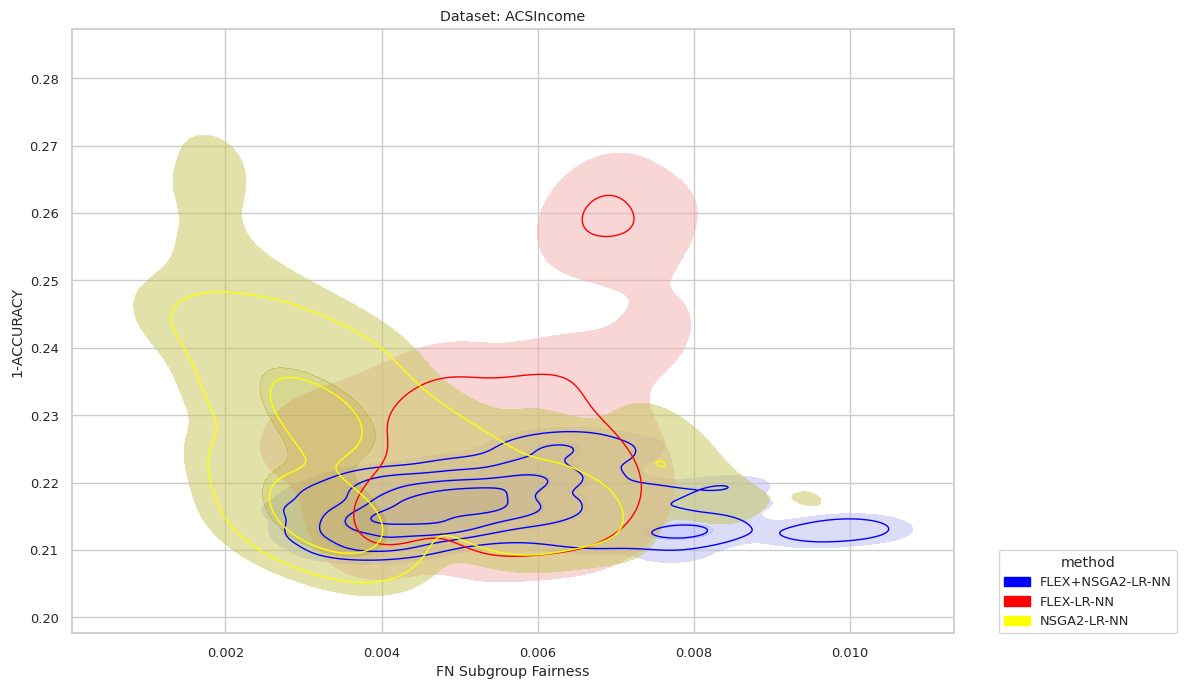

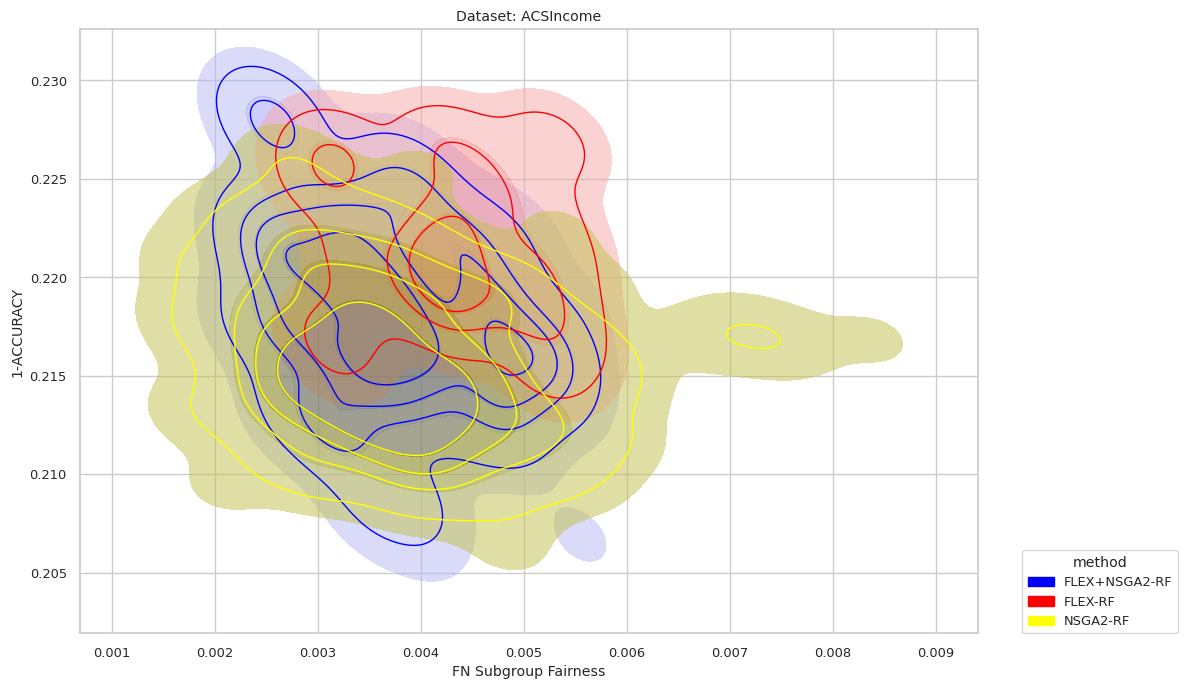

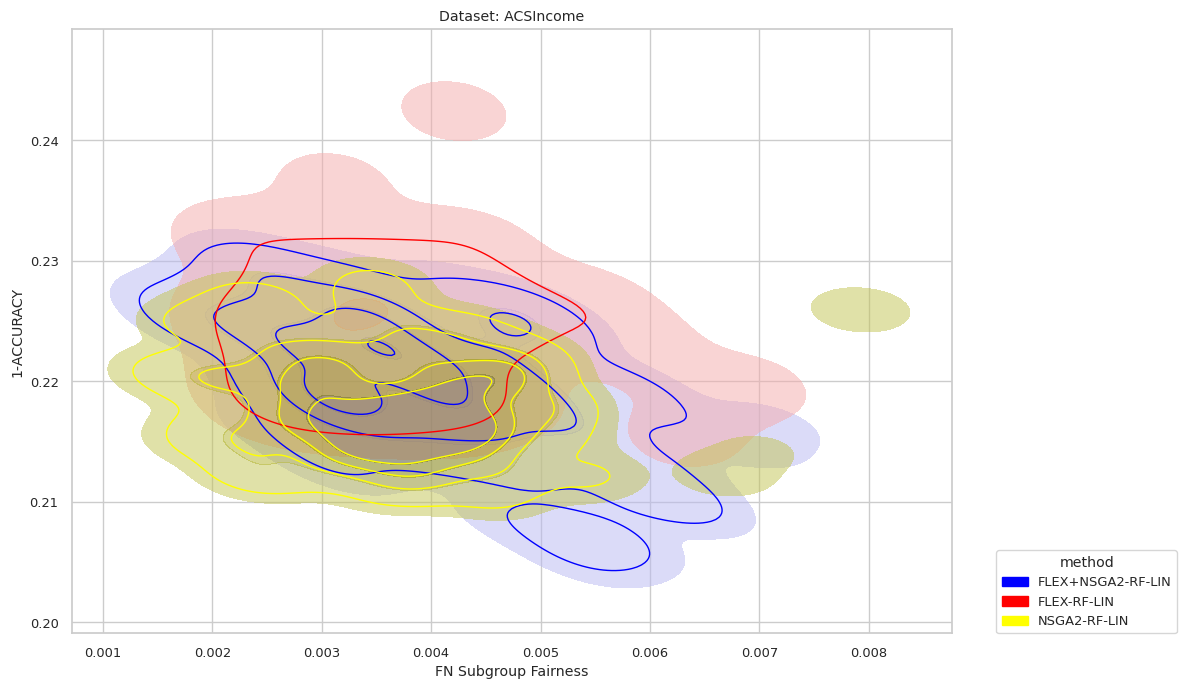

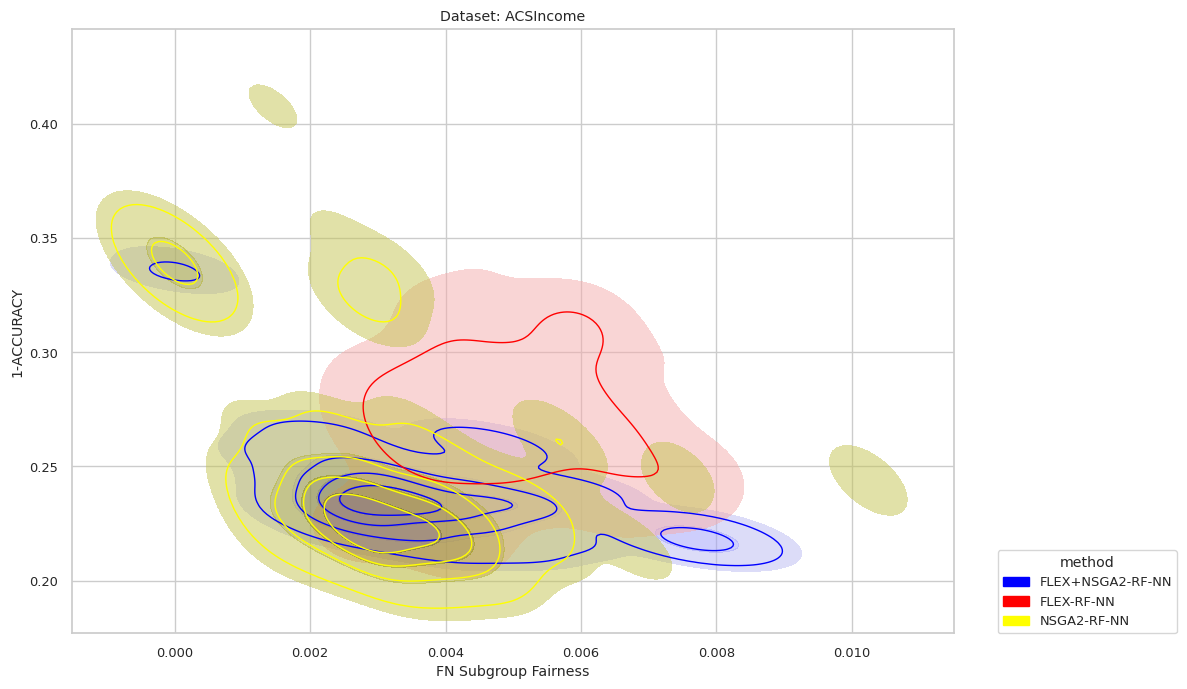

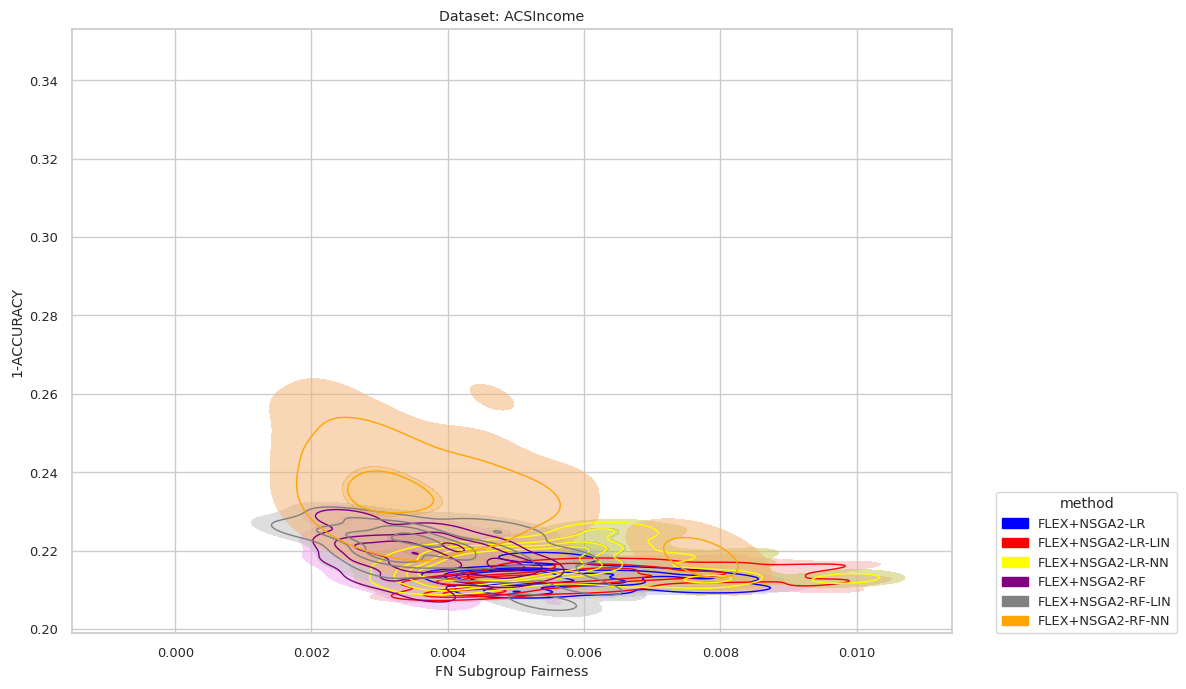

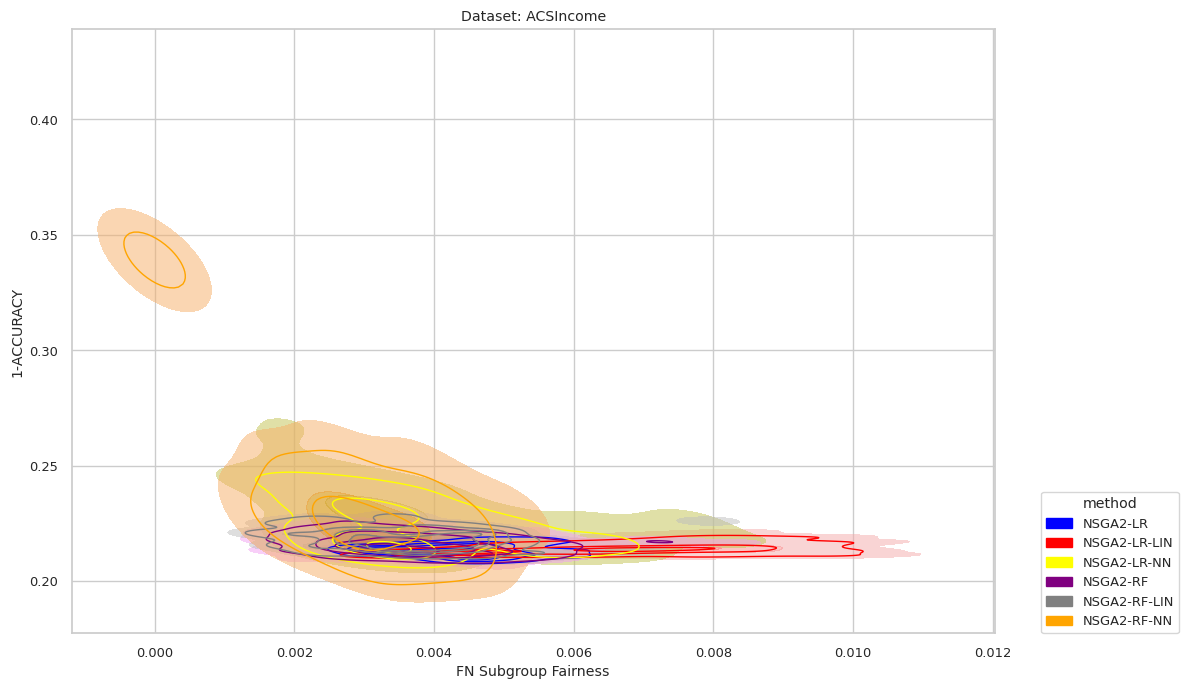

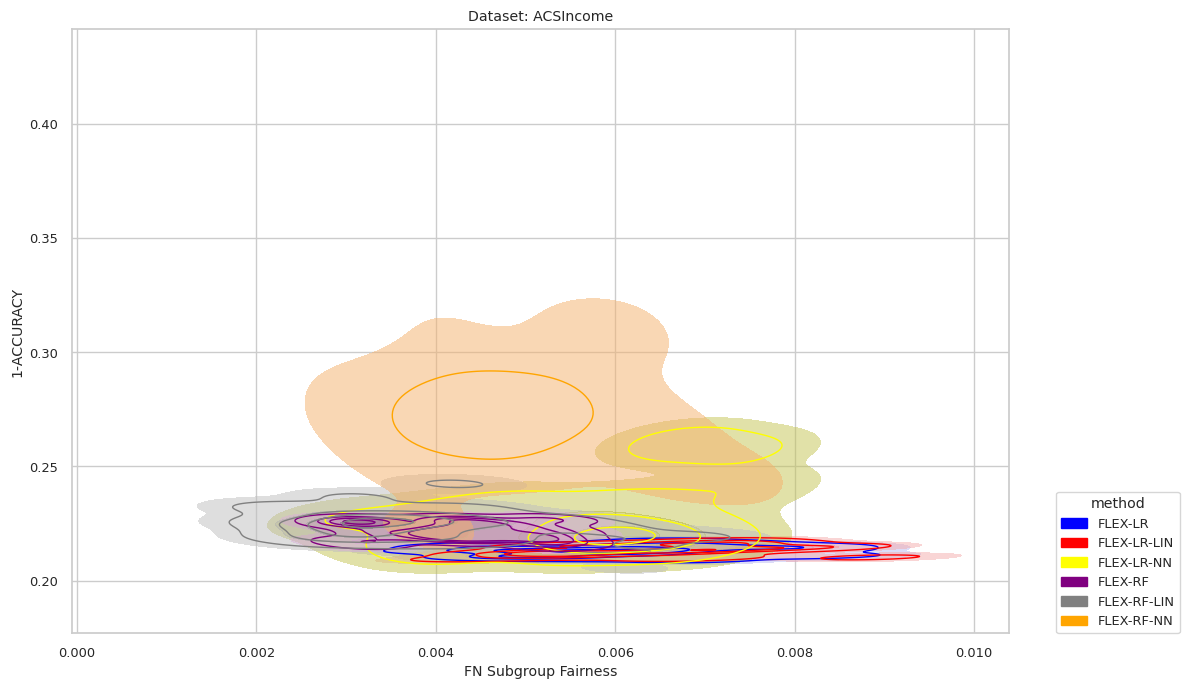

In [7]:
sns.set(style='whitegrid',font_scale=0.85)
#size = 10


for p, values in plot_dict.items():
    
    df_plt = df_results.copy()
    df_plt = df_plt.loc[
    #     (df_plt.method.str.contains('fnr'))
    #     & 
        (df_plt.fold == 'test')
        &
        (df_plt.dataset.isin(['ACSIncome']))
        #&
        #df_plt.method.str.contains('FLEX-', case=False) #& ~df_plt.method.str.contains('LR', case=False)
        &
        (df_plt.method.isin(values))
    ]
    hue_order = values
    custom_palette = sns.color_palette(['blue', 'red', 'yellow', 'purple', 'gray', 'orange'])

    x = 'Subgroup Fairness'
    y = '1-Accuracy'
    # hue = 'base_method'
    hue = 'method'
    style='ML'
    col='dataset'
    row='fairness'
    palette=custom_palette


    i = 0
    for r, dfr in df_plt.groupby(row):
        j = 0
        for c, dfrc in dfr.groupby(col):
            fig, ax = plt.subplots(figsize=(12, 7))
            #ax = axs[i,j]
            shared_args = dict(
                ax=ax, 
                data=dfrc,  
                x=x, 
                y=y,
                hue=hue,
                hue_order=hue_order,
                palette=palette
            )

    #         xlim = ax.get_xlim()
    #         ylim = ax.get_ylim()

            legend = i==0 and j+1 == df_plt[col].nunique()
            try:
                g = sns.kdeplot(**shared_args,
                            levels=5,
                            #color="r",
                            fill=True,
                            linewidths=1,
                            legend=legend,
                            alpha=0.5, 
                            thresh=0.01    
                           )
                sns.kdeplot(**shared_args,
                            levels=5,
                            fill=False,
                            linewidths=1,
                            legend=False,
                            #thresh=0.01
                           )
    #             sns.scatterplot(
    #                 **shared_args, 
    #                 s=20,
    #                 legend = False,
    #             )

    #             print()
            except:
                print('kde failed for',r,c)
    #             sns.scatterplot(
    #                 **shared_args, 
    #                 s=5,
    #                 legend = False,
    #             )
                sns.histplot(**shared_args,
                             bins=20,
        #                      pthresh=.01,
                             thresh=1,
                             legend=False
                            )

    #         ax.set_xlim(xlim)
    #         ax.set_ylim(ylim)
            if i == 0: 

                ax.set_title(f'Dataset: {c}')

            ax.set_xlabel(f'{r[:2]} Subgroup Fairness')

            if j == 0:
                ax.set_ylabel(f'{y.upper()}')

            else:
                ax.set_ylabel('')

            if legend:
                sns.move_legend(g, loc=[1.05,0])

            j += 1
        i += 1

    #plt.figure(figsize=(10, 6))
    plt.tight_layout()

    #f.tight_layout()
    plt.savefig(f'figs9/pareto_dist/pareto_dist_{p}_ACSIncomeRS.png', bbox_inches='tight')


In [121]:
# plt.show()